In [44]:
import numpy as np
import requests
import pandas as pd
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import skew, kurtosis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

* Requete  pour avoir les données Via  l'API

In [35]:
# ---- CONFIGURATION ----
cryptos = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']
interval = '1h'
start_date = '2020-02-01'
end_date = '2025-05-01'
limit = 1000  # maximum autorisé par requête

def date_to_ms(date_str):
    dt = datetime.strptime(date_str, "%Y-%m-%d")
    return int(dt.timestamp() * 1000)

def fetch_binance_ohlc(symbol, interval, start_ms, end_ms):
    url = 'https://api.binance.com/api/v3/klines'
    all_data = []
    while start_ms < end_ms:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': start_ms,
            'endTime': end_ms,
            'limit': limit
        }
        response = requests.get(url, params=params)
        data = response.json()
        if not data:
            break
        all_data.extend(data)
        start_ms = data[-1][0] + 1
        time.sleep(0.3)  # évite le blocage par Binance
    return all_data

def process_ohlc(data, symbol):
    df = pd.DataFrame(data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_volume', 'nb_trades', 'taker_buy_base',
        'taker_buy_quote', 'ignore'
    ])
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['close'] = df['close'].astype(float)
    return df[['datetime', 'close']].rename(columns={'close': f'{symbol}_close'})

# ---- TÉLÉCHARGEMENT ----
start_ms = date_to_ms(start_date)
end_ms = date_to_ms(end_date)

merged_df = None
for symbol in cryptos:
    print(f"Téléchargement de {symbol}...")
    raw_data = fetch_binance_ohlc(symbol, interval, start_ms, end_ms)
    df = process_ohlc(raw_data, symbol)
    if merged_df is None:
        merged_df = df
    else:
        merged_df = pd.merge(merged_df, df, on='datetime', how='outer')

# ---- EXPORT ----
merged_df.sort_values('datetime', inplace=True)
merged_df.to_csv("crypto_hourly_prices_2020_2025.csv", index=False)
print("Fichier exporté : crypto_hourly_prices_2020_2025.csv")


Téléchargement de BTCUSDT...


KeyboardInterrupt: 

* Importation des données

In [36]:
df_crypto = pd.read_csv(r"C:\Users\kadas\Desktop\Mes_cours\chaffik\Data\crypto_hourly_prices_2020_2025.csv", parse_dates=['datetime'])

* forme de la donnée

In [37]:
df_crypto.shape

(45952, 6)

* Vue sur un echantillon

In [38]:
df_crypto.head(5)

,datetime,BTCUSDT_close,ETHUSDT_close,XRPUSDT_close,LTCUSDT_close,DOGEUSDT_close
0,2020-01-31 23:00:00,9352.89,179.99,0.23946,68.00,0.002378
1,2020-02-01 00:00:00,9383.07,181.09,0.24097,68.46,0.002388
2,2020-02-01 01:00:00,9429.86,183.76,0.24265,72.01,0.002400
3,2020-02-01 02:00:00,9441.88,183.88,0.24251,71.70,0.002410
4,2020-02-01 03:00:00,9432.33,183.51,0.24175,72.74,0.002401


* Pourcentage de valeurs manquantes

In [ ]:
df_crypto.isna().mean()*100

datetime          0.0
BTCUSDT_close     0.0
ETHUSDT_close     0.0
XRPUSDT_close     0.0
LTCUSDT_close     0.0
DOGEUSDT_close    0.0
dtype: float64

#### Normalisation des données 

In [ ]:
def compute_returns(df_prices):
    """
    À partir d’un DataFrame contenant les colonnes *_close, 
    calcule log-return, centered, standardized, abs-standardized pour chaque crypto.
    """
    df = df_prices.copy()
    crypto_cols = [col for col in df.columns if col.endswith('_close')]

    for col in crypto_cols:
        base = col.replace('_close', '')
        
        # Log-returns : Rendement logarithmique horaire de chaque crypto
        df[f'{base}_log_return'] = np.log(df[col] / df[col].shift(1))
        
        # Moyenne et écart-type (en excluant le premier NaN)
        r = df[f'{base}_log_return']
        mean_r = r.mean()
        std_r = r.std()
        
        # Centrage : Rendements centrés autour de la moyenne
        df[f'{base}_log_return_centered'] = r - mean_r
        
        # Standardisation classique
        df[f'{base}_log_return_std'] = (r - mean_r) / std_r
        
        # Valeur absolue (pour NNAR ou Kalman) : 	Volatilité observable, proxy pour l'entraînement & évaluation

        df[f'{base}_abs_std_return'] = df[f'{base}_log_return_std'].abs()

    return df


* Application de la fonction

In [42]:
df_cryto_prepared = compute_returns(df_crypto)
df_cryto_prepared.head(5)

,datetime,BTCUSDT_close,ETHUSDT_close,XRPUSDT_close,LTCUSDT_close,DOGEUSDT_close,BTCUSDT_log_return,BTCUSDT_log_return_centered,BTCUSDT_log_return_std,BTCUSDT_abs_std_return,...,XRPUSDT_log_return_std,XRPUSDT_abs_std_return,LTCUSDT_log_return,LTCUSDT_log_return_centered,LTCUSDT_log_return_std,LTCUSDT_abs_std_return,DOGEUSDT_log_return,DOGEUSDT_log_return_centered,DOGEUSDT_log_return_std,DOGEUSDT_abs_std_return
0,2020-01-31 23:00:00,9352.89,179.99,0.23946,68.00,0.002378,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-01 00:00:00,9383.07,181.09,0.24097,68.46,0.002388,0.003222,0.003171,0.453242,0.453242,...,0.540048,0.540048,0.006742,0.006737,0.647038,0.647038,0.004490,0.004397,0.306001,0.306001
2,2020-02-01 01:00:00,9429.86,183.76,0.24265,72.01,0.002400,0.004974,0.004924,0.703722,0.703722,...,0.597325,0.597325,0.050555,0.050551,4.854713,4.854713,0.004679,0.004585,0.319107,0.319107
3,2020-02-01 02:00:00,9441.88,183.88,0.24251,71.70,0.002410,0.001274,0.001224,0.174875,0.174875,...,-0.054139,0.054139,-0.004314,-0.004319,-0.414754,0.414754,0.004366,0.004273,0.297380,0.297380
4,2020-02-01 03:00:00,9432.33,183.51,0.24175,72.74,0.002401,-0.001012,-0.001062,-0.151807,0.151807,...,-0.275919,0.275919,0.014401,0.014396,1.382557,1.382557,-0.003825,-0.003918,-0.272662,0.272662


In [45]:
df_cryto_prepared.columns

Index(['datetime', 'BTCUSDT_close', 'ETHUSDT_close', 'XRPUSDT_close',
       'LTCUSDT_close', 'DOGEUSDT_close', 'BTCUSDT_log_return',
       'BTCUSDT_log_return_centered', 'BTCUSDT_log_return_std',
       'BTCUSDT_abs_std_return', 'ETHUSDT_log_return',
       'ETHUSDT_log_return_centered', 'ETHUSDT_log_return_std',
       'ETHUSDT_abs_std_return', 'XRPUSDT_log_return',
       'XRPUSDT_log_return_centered', 'XRPUSDT_log_return_std',
       'XRPUSDT_abs_std_return', 'LTCUSDT_log_return',
       'LTCUSDT_log_return_centered', 'LTCUSDT_log_return_std',
       'LTCUSDT_abs_std_return', 'DOGEUSDT_log_return',
       'DOGEUSDT_log_return_centered', 'DOGEUSDT_log_return_std',
       'DOGEUSDT_abs_std_return'],
      dtype='object')

 * Analyse exploratoire des rendements (log_return)

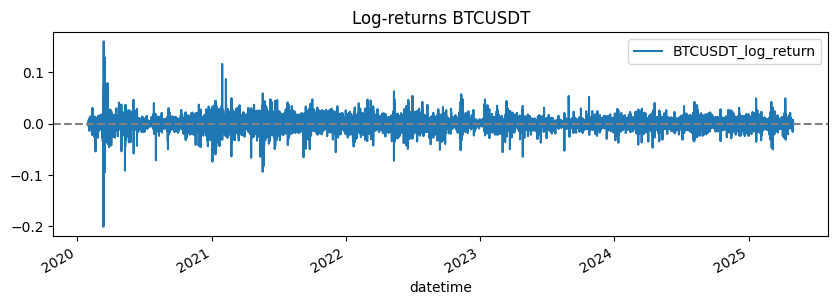

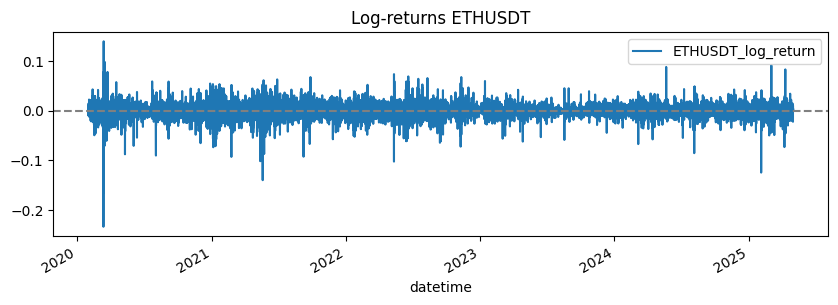

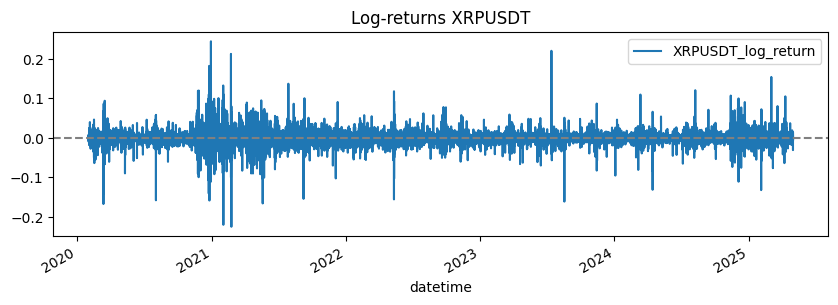

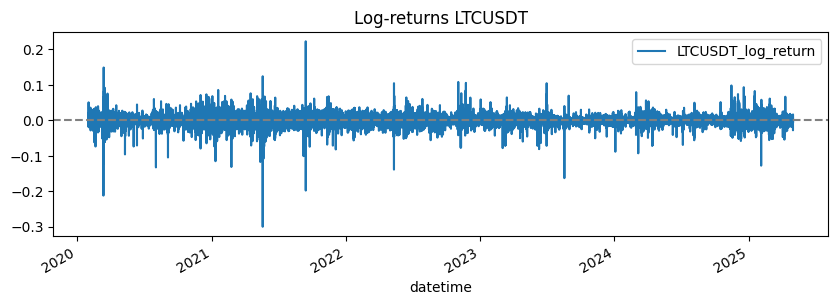

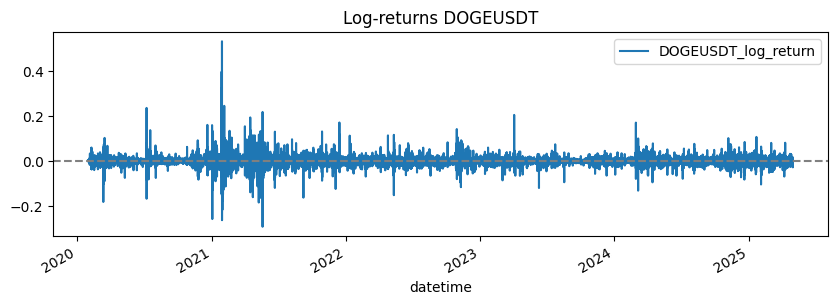

In [47]:
for crypto in ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']:
    df_cryto_prepared.plot(
        x='datetime',
        y=f'{crypto}_log_return',
        title=f'Log-returns {crypto}',
        figsize=(10, 3)
    )
    plt.axhline(0, linestyle='--', color='grey')
    plt.show()


* Histogrammes + courbe normale

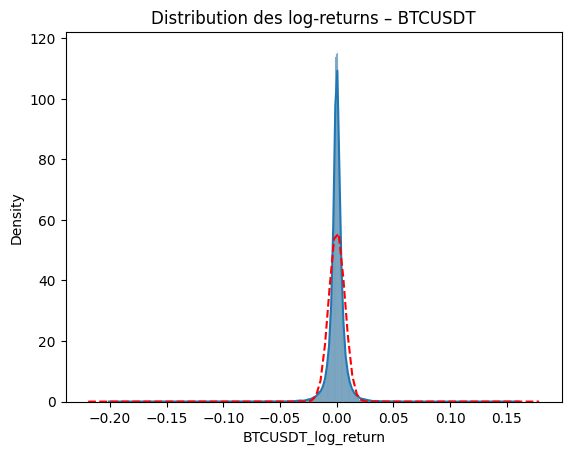

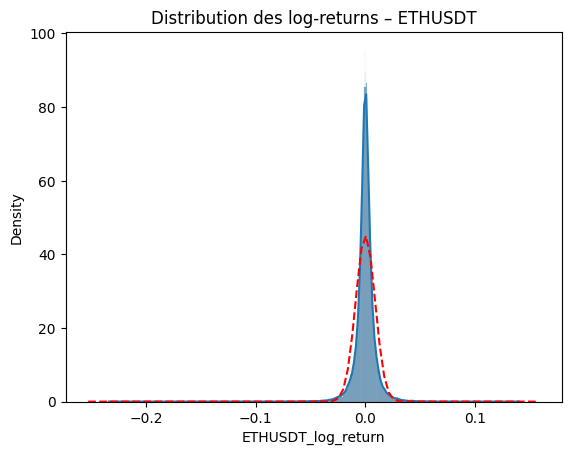

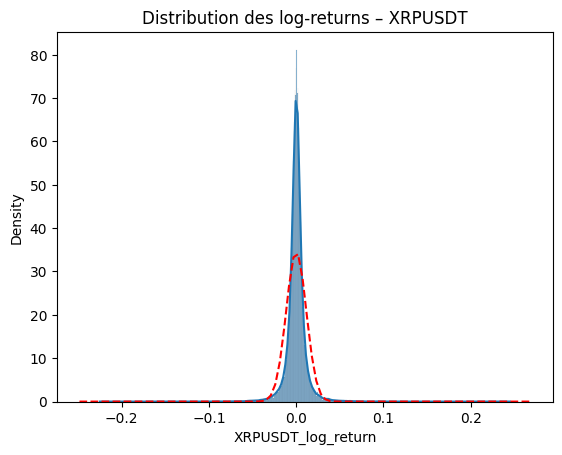

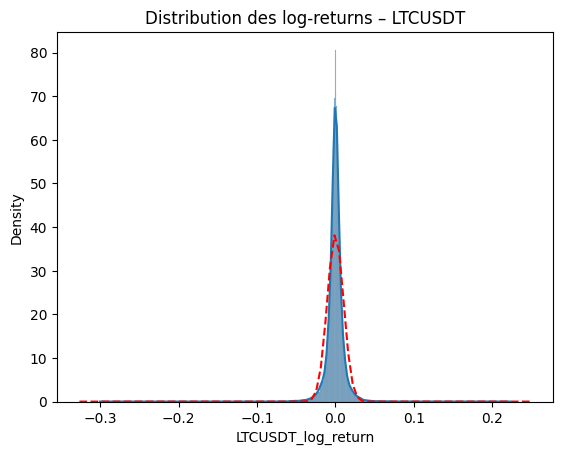

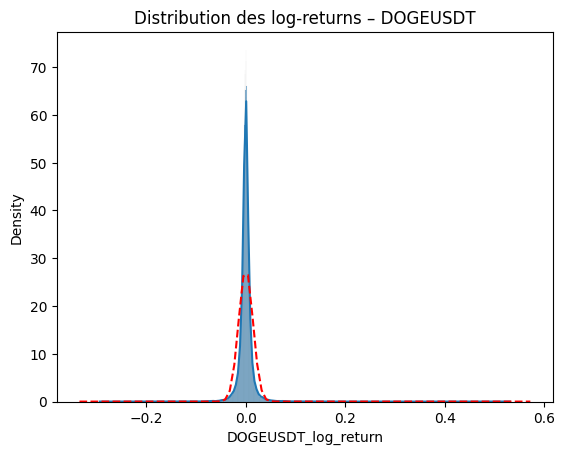

In [48]:
for crypto in ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']:
    r = df_cryto_prepared[f'{crypto}_log_return'].dropna()
    sns.histplot(r, kde=True, stat='density')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    plt.plot(x, norm.pdf(x, r.mean(), r.std()), 'r--')
    plt.title(f'Distribution des log-returns – {crypto}')
    plt.show()


* Skewness & Kurtosis

In [50]:
for crypto in ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']:
    r = df_cryto_prepared[f'{crypto}_log_return'].dropna()
    print(f"{crypto} | Skew: {skew(r):.2f} | Kurtosis: {kurtosis(r):.2f}")

BTCUSDT | Skew: -0.96 | Kurtosis: 52.05
ETHUSDT | Skew: -0.98 | Kurtosis: 29.63
XRPUSDT | Skew: -0.04 | Kurtosis: 41.21
LTCUSDT | Skew: -1.02 | Kurtosis: 41.60
DOGEUSDT | Skew: 2.26 | Kurtosis: 107.06


# Autocorrélation et stationnarité

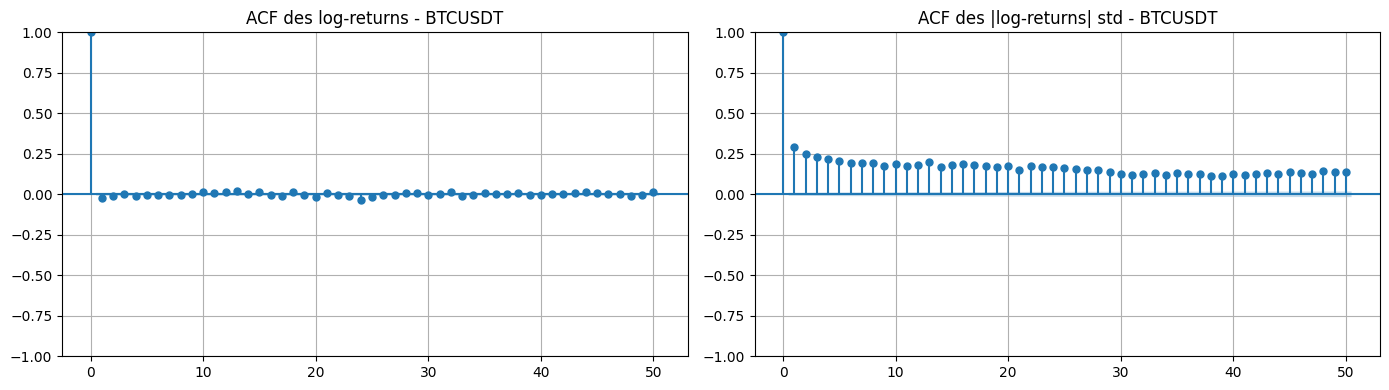

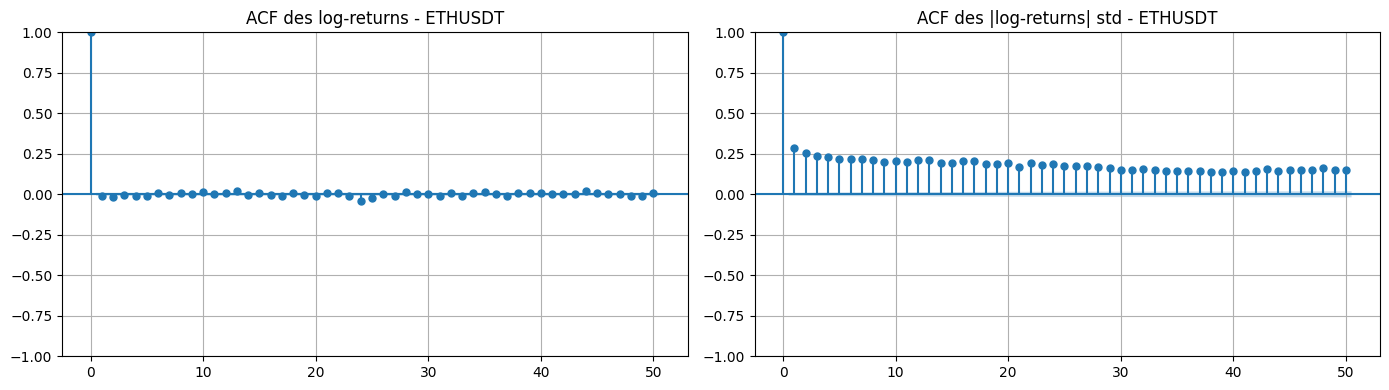

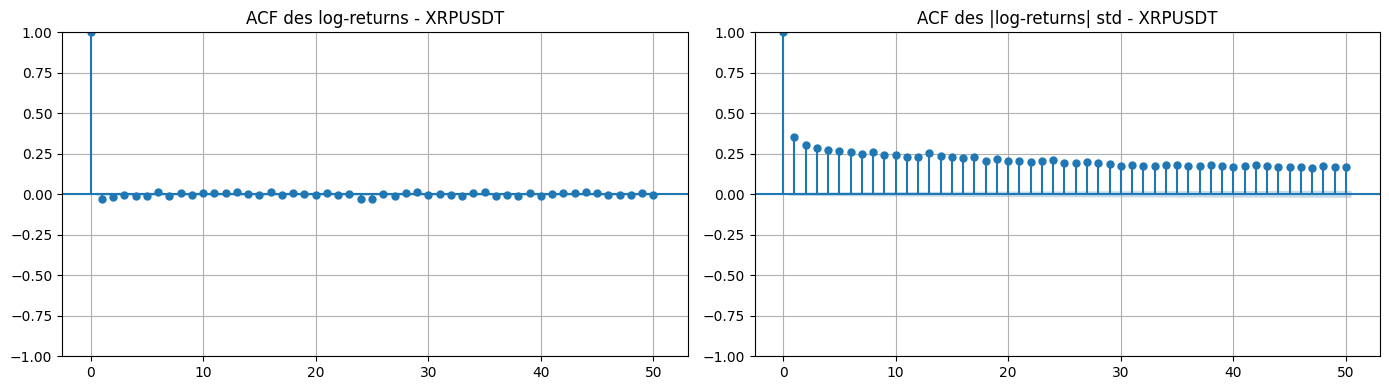

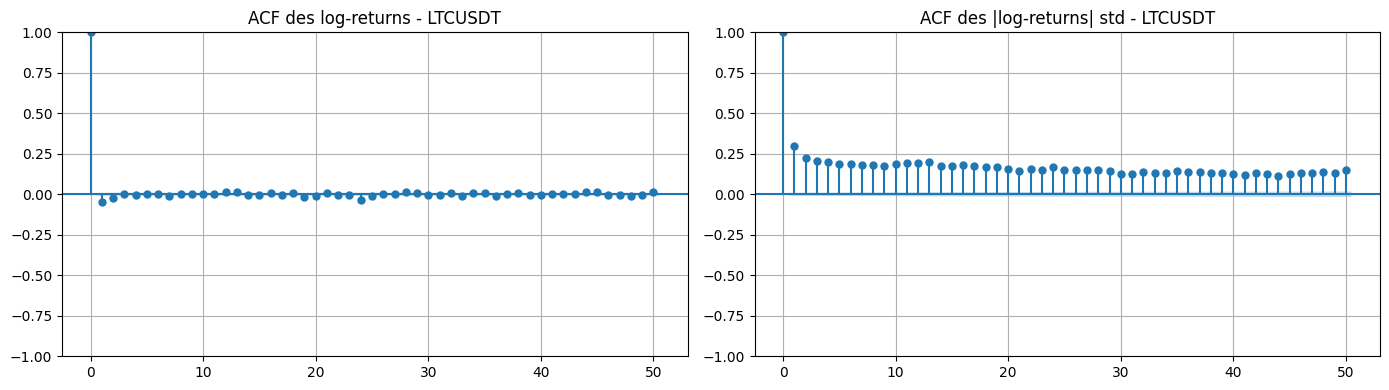

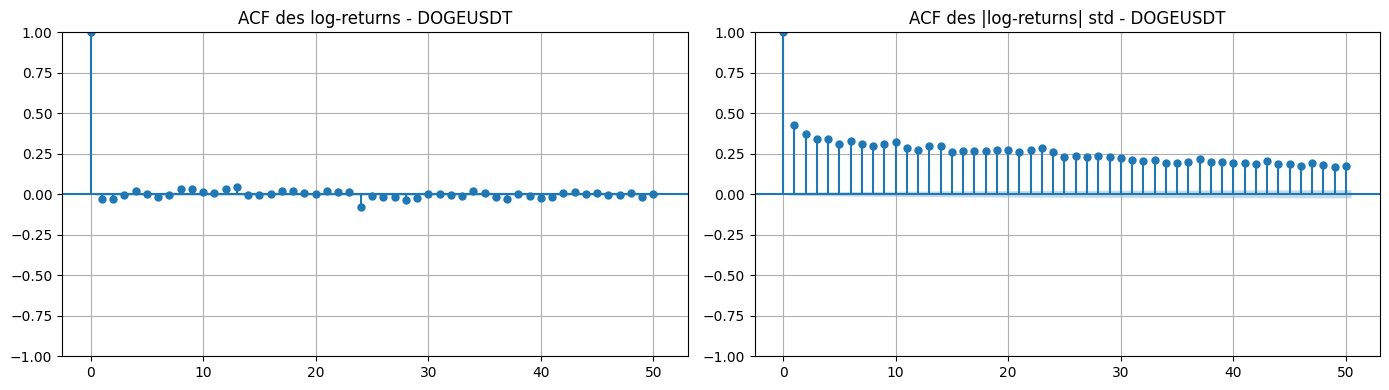

In [59]:
#  ACF / PACF sur log_return et abs_log_return

cryptos = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']

for crypto in cryptos:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # ACF log-return
    plot_acf(
        df_cryto_prepared[f'{crypto}_log_return'].dropna(),
        lags=50,
        ax=axes[0]
    )
    axes[0].set_title(f"ACF des log-returns - {crypto}")
    axes[0].grid(True)

    # ACF |log-return| standardisé
    plot_acf(
        df_cryto_prepared[f'{crypto}_abs_std_return'].dropna(),
        lags=50,
        ax=axes[1]
    )
    axes[1].set_title(f"ACF des |log-returns| std - {crypto}")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

* Test de stationnarité (Augmented Dickey-Fuller)

In [58]:
for crypto in ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'DOGEUSDT']:
    r = df_cryto_prepared[f'{crypto}_log_return'].dropna()
    adf = adfuller(r)
    print(f"{crypto} – ADF Statistic: {adf[0]:.3f}, p-value: {adf[1]:.3f}")

BTCUSDT – ADF Statistic: -29.785, p-value: 0.000
ETHUSDT – ADF Statistic: -29.616, p-value: 0.000
XRPUSDT – ADF Statistic: -31.329, p-value: 0.000
LTCUSDT – ADF Statistic: -30.356, p-value: 0.000
DOGEUSDT – ADF Statistic: -29.055, p-value: 0.000


Les p-value < 0.05, on rejette H₀ → la série est stationnaire , Tous les log-returns de cryptos sont en général stationnaires, ce qui est une bonne base pour les modèles

* Construction d’une série de volatilité observée

On construis pour chaque crypto une série de volatilité observée lissée, en prenant la moyenne mobile des rendements standardisés absolus sur un pas de 24 heures.

C’est notre "vérité terrain" pour la comparaison des modèles Elle te servira de benchmark ppur  nos métrics

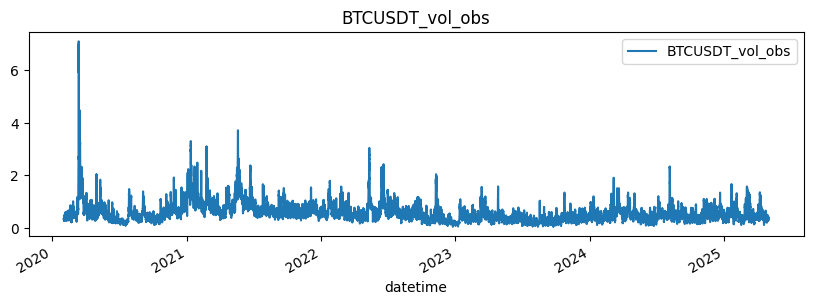

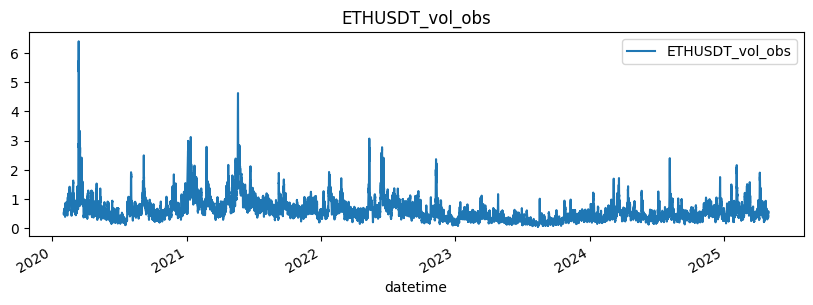

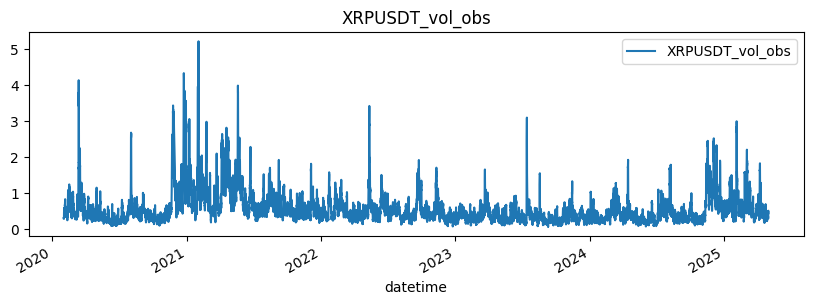

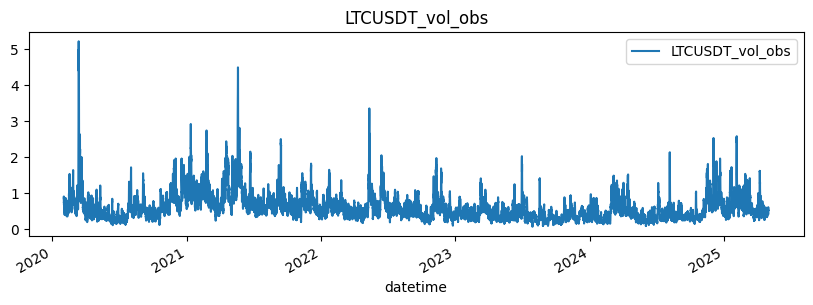

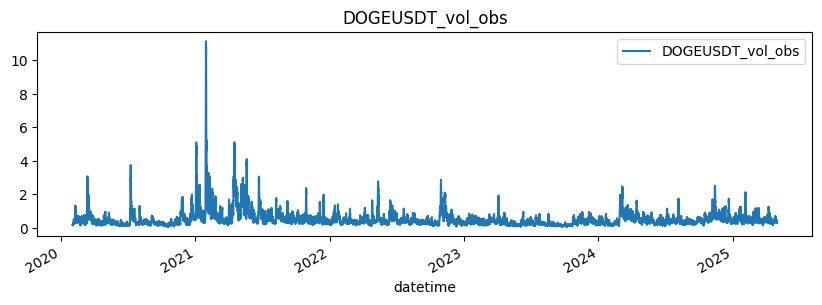

In [61]:
# Détecte toutes les colonnes *_abs_std_return automatiquement
vol_columns = [col for col in df_cryto_prepared.columns if col.endswith('_abs_std_return')]

for col in vol_columns:
    base = col.replace('_abs_std_return', '')  # ex: BTCUSDT ou BTC selon renommage
    df_cryto_prepared[f'{base}_vol_obs'] = df_cryto_prepared[col].rolling(window=24).mean()
for col in df_cryto_prepared.columns:
    if col.endswith('_vol_obs'):
        df_cryto_prepared.plot(x='datetime', y=col, title=col, figsize=(10, 3))
        plt.show()

In [64]:
df_cryto_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45952 entries, 0 to 45951
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   datetime                      45952 non-null  datetime64[ns]
 1   BTCUSDT_close                 45952 non-null  float64       
 2   ETHUSDT_close                 45952 non-null  float64       
 3   XRPUSDT_close                 45952 non-null  float64       
 4   LTCUSDT_close                 45952 non-null  float64       
 5   DOGEUSDT_close                45952 non-null  float64       
 6   BTCUSDT_log_return            45951 non-null  float64       
 7   BTCUSDT_log_return_centered   45951 non-null  float64       
 8   BTCUSDT_log_return_std        45951 non-null  float64       
 9   BTCUSDT_abs_std_return        45951 non-null  float64       
 10  ETHUSDT_log_return            45951 non-null  float64       
 11  ETHUSDT_log_return_centered 

# Implémentation des modèles